In [25]:
#Imports and setup
import os
import random
import math
from collections import deque
import numpy as np
import time
import string
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

print(" Environment ready.")
DEVICE = torch.device("mps" if torch.mps.is_available() else "cpu")
print("Using device:", DEVICE)


 Environment ready.
Using device: cpu


In [26]:
#Load and clean corpus.txt and test.txt
def clean_wordlist(path):
    words = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            w = line.strip().lower()
            # Keep only alphabetic words
            if w and all(ch in string.ascii_lowercase for ch in w):
                words.append(w)
    # Remove duplicates
    words = list(sorted(set(words)))
    return words

if not os.path.exists("corpus.txt") or not os.path.exists("test.txt"):
    raise FileNotFoundError("corpus.txt or test.txt not found in current directory.")

corpus = clean_wordlist("corpus.txt")
test_words = clean_wordlist("test.txt")

print(f"Loaded and cleaned corpus: {len(corpus)} unique words")
print(f"Loaded and cleaned test set: {len(test_words)} unique words")

alphabet = list(string.ascii_lowercase)
max_word_len = max(len(w) for w in corpus)
print("Alphabet size:", len(alphabet), "| Max word length:", max_word_len)


Loaded and cleaned corpus: 49397 unique words
Loaded and cleaned test set: 2000 unique words
Alphabet size: 26 | Max word length: 24


In [27]:
# Cell 3: Hidden Markov Model (character bigram)
class CharHMM:
    def __init__(self, alphabet):
        self.alphabet = alphabet
        self.idx = {c: i for i, c in enumerate(alphabet)}
        self.V = len(alphabet)
        self.smoothing = 1.0

    def train(self, words):
        self.start_counts = np.zeros(self.V)
        self.trans_counts = np.zeros((self.V, self.V))
        for w in words:
            if not w: continue
            first = w[0]
            if first in self.idx:
                self.start_counts[self.idx[first]] += 1
            for a, b in zip(w, w[1:]):
                if a in self.idx and b in self.idx:
                    self.trans_counts[self.idx[a], self.idx[b]] += 1

        self.start_probs = (self.start_counts + self.smoothing) / (self.start_counts.sum() + self.smoothing * self.V)
        self.trans_probs = (self.trans_counts + self.smoothing) / (self.trans_counts.sum(axis=1, keepdims=True) + self.smoothing * self.V)
        self.log_start = np.log(self.start_probs)
        self.log_trans = np.log(self.trans_probs)

    def logprob_word(self, w):
        if not w: return -1e9
        lp = self.log_start[self.idx.get(w[0], 0)]
        for a, b in zip(w, w[1:]):
            i, j = self.idx.get(a, 0), self.idx.get(b, 0)
            lp += self.log_trans[i, j]
        return lp

    def letter_distribution(self, pattern, guessed, words):
        patt_len = len(pattern)
        candidates = [w for w in words if len(w) == patt_len and all(
            (pattern[i] == '_' or pattern[i] == w[i]) for i in range(patt_len)
        )]
        if not candidates:
            candidates = [w for w in words if len(w) == patt_len]
        logps = np.array([self.logprob_word(w) for w in candidates])
        probs = np.exp(logps - np.max(logps))
        probs /= probs.sum()
        letter_probs = np.zeros(self.V)
        for w, p in zip(candidates, probs):
            for i, ch in enumerate(w):
                if pattern[i] == '_':
                    letter_probs[self.idx[ch]] += p
        for g in guessed:
            if g in self.idx:
                letter_probs[self.idx[g]] = 0
        if letter_probs.sum() == 0:
            letter_probs += 1
        return letter_probs / letter_probs.sum()

hmm = CharHMM(alphabet)
hmm.train(corpus)
print("HMM trained successfully.")


HMM trained successfully.


In [28]:
#Hangman environment
class HangmanEnv:
    def __init__(self, word, hmm, max_wrong=6, corpus=None):
        self.word = word
        self.hmm = hmm
        self.corpus = corpus
        self.max_wrong = max_wrong
        self.reset()

    def reset(self):
        self.mask = ['_'] * len(self.word)
        self.guessed = set()
        self.wrong = 0
        self.repeated = 0
        self.done = False
        return self._obs()

    def _obs(self):
        pattern = ''.join(self.mask)
        hmm_probs = self.hmm.letter_distribution(pattern, self.guessed, self.corpus)
        return {"pattern": pattern, "guessed": set(self.guessed), "lives": self.max_wrong - self.wrong, "hmm_probs": hmm_probs}

    def step(self, letter):
        if self.done:
            raise ValueError("Game already finished!")
        if letter in self.guessed:
            self.repeated += 1
            return self._obs(), -2, False, {}
        self.guessed.add(letter)
        if letter in self.word:
            for i, c in enumerate(self.word):
                if c == letter:
                    self.mask[i] = letter
            reward = 1
        else:
            self.wrong += 1
            reward = -1
        done = False
        info = {}
        if '_' not in self.mask:
            reward += 10
            done = True
            info['result'] = 'win'
        elif self.wrong >= self.max_wrong:
            reward -= 5
            done = True
            info['result'] = 'lose'
        self.done = done
        return self._obs(), reward, done, info


In [29]:
#Encode observation -> numeric vector
MAX_LEN = max_word_len

def encode_pattern(p):
    arr = np.zeros((MAX_LEN, 27), dtype=np.float32)
    for i in range(MAX_LEN):
        if i < len(p):
            ch = p[i]
            arr[i, 26 if ch == '_' else alphabet.index(ch)] = 1
        else:
            arr[i, 26] = 1
    return arr.flatten()

def obs_to_vec(obs):
    patt = encode_pattern(obs["pattern"])
    guessed = np.zeros(26)
    for g in obs["guessed"]:
        guessed[alphabet.index(g)] = 1
    return np.concatenate([patt, guessed, obs["hmm_probs"], [obs["lives"]/6]], dtype=np.float32)

def mask_actions(obs):
    mask = np.ones(26)
    for g in obs["guessed"]:
        mask[alphabet.index(g)] = 0
    return mask


In [30]:
#DQN model and replay buffer
STATE_DIM = MAX_LEN * 27 + 26 + 26 + 1
ACTION_DIM = 26

class DQN(nn.Module):
    def __init__(self, s_dim, a_dim, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(s_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, a_dim)
        )
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, cap=20000):
        self.buffer = deque(maxlen=cap)
    def push(self, *args):
        self.buffer.append(args)
    def sample(self, n):
        s, a, r, ns, d, m = zip(*random.sample(self.buffer, n))
        return np.stack(s), a, r, np.stack(ns), d, np.stack(m)
    def __len__(self): return len(self.buffer)

policy_net = DQN(STATE_DIM, ACTION_DIM).to(DEVICE)
target_net = DQN(STATE_DIM, ACTION_DIM).to(DEVICE)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
replay = ReplayBuffer(50000)
criterion = nn.MSELoss()


In [31]:
#Training loop
episodes = 4000
gamma = 0.99
batch = 64
eps_start, eps_end = 1.0, 0.05
eps_decay = 3000
target_update = 200
learn_start = 2000
learn_every = 4
episode_rewards = []

def epsilon(ep):
    return eps_end + (eps_start - eps_end) * math.exp(-ep / eps_decay)

for ep in range(1, episodes + 1):
    word = random.choice(corpus)
    env = HangmanEnv(word, hmm, max_wrong=6, corpus=corpus)
    obs = env.reset()
    state = obs_to_vec(obs)
    total_r = 0
    for t in range(26):
        eps = epsilon(ep)
        mask = mask_actions(obs)
        if random.random() < eps:
            avail = np.where(mask > 0.5)[0]
            act = int(np.random.choice(avail))
        else:
            with torch.no_grad():
                qv = policy_net(torch.tensor(state).float().to(DEVICE).unsqueeze(0)).cpu().numpy().squeeze()
            qv -= (1 - mask) * 1e6
            act = int(np.argmax(qv))
        letter = alphabet[act]
        new_obs, r, done, info = env.step(letter)
        new_state = obs_to_vec(new_obs)
        new_mask = mask_actions(new_obs)
        replay.push(state, act, r, new_state, done, new_mask)
        state, obs = new_state, new_obs
        total_r += r

        if len(replay) > learn_start and t % learn_every == 0:
            s, a, r, ns, d, m = replay.sample(batch)
            s, ns = torch.tensor(s, dtype=torch.float32, device=DEVICE), torch.tensor(ns, dtype=torch.float32, device=DEVICE)
            a = torch.tensor(a, dtype=torch.long, device=DEVICE)
            r = torch.tensor(r, dtype=torch.float32, device=DEVICE)
            d = torch.tensor(d, dtype=torch.float32, device=DEVICE)
            m = torch.tensor(m, dtype=torch.float32, device=DEVICE)

            qv = policy_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                nqv = target_net(ns)
                nqv = nqv + (-1e6) * (1 - m)
                q_target = r + gamma * (1 - d) * nqv.max(1)[0]
            loss = criterion(qv, q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    episode_rewards.append(total_r)
    if ep % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if ep % 200 == 0:
        avg_r = np.mean(episode_rewards[-200:])
        print(f"Ep {ep}/{episodes} | AvgReward={avg_r:.2f} | eps={eps:.2f}")

print("Training done.")


Ep 200/4000 | AvgReward=-8.54 | eps=0.94
Ep 400/4000 | AvgReward=-8.12 | eps=0.88
Ep 600/4000 | AvgReward=-8.19 | eps=0.83
Ep 800/4000 | AvgReward=-8.09 | eps=0.78
Ep 1000/4000 | AvgReward=-7.49 | eps=0.73
Ep 1200/4000 | AvgReward=-7.34 | eps=0.69
Ep 1400/4000 | AvgReward=-7.42 | eps=0.65
Ep 1600/4000 | AvgReward=-6.89 | eps=0.61
Ep 1800/4000 | AvgReward=-6.75 | eps=0.57
Ep 2000/4000 | AvgReward=-6.58 | eps=0.54
Ep 2200/4000 | AvgReward=-5.58 | eps=0.51
Ep 2400/4000 | AvgReward=-5.33 | eps=0.48
Ep 2600/4000 | AvgReward=-5.46 | eps=0.45
Ep 2800/4000 | AvgReward=-5.33 | eps=0.42
Ep 3000/4000 | AvgReward=-3.88 | eps=0.40
Ep 3200/4000 | AvgReward=-3.07 | eps=0.38
Ep 3400/4000 | AvgReward=-3.16 | eps=0.36
Ep 3600/4000 | AvgReward=-2.98 | eps=0.34
Ep 3800/4000 | AvgReward=-2.12 | eps=0.32
Ep 4000/4000 | AvgReward=-0.59 | eps=0.30
Training done.


In [32]:
# Cell 9: Evaluate trained agent
def evaluate(model, words, n_games=1000):
    wins = wrong = rep = 0
    for _ in range(n_games):
        w = random.choice(words)
        env = HangmanEnv(w, hmm, 6, corpus)
        obs = env.reset()
        done = False
        while not done:
            state = obs_to_vec(obs)
            mask = mask_actions(obs)
            with torch.no_grad():
                qv = model(torch.tensor(state).float().to(DEVICE).unsqueeze(0)).cpu().numpy().squeeze()
            qv -= (1 - mask) * 1e6
            act = int(np.argmax(qv))
            letter = alphabet[act]
            obs, r, done, info = env.step(letter)
        if info.get('result') == 'win':
            wins += 1
        wrong += env.wrong
        rep += env.repeated
    sr = wins / n_games
    score = (sr * n_games) - (wrong * 5) - (rep * 2)
    print(f"Evaluation complete: SuccessRate={sr*100:.2f}% | Avg wrong={wrong/n_games:.2f} | Avg repeat={rep/n_games:.2f}")
    print(f"Final Score = {score:.2f}")
    return sr, score

evaluate(policy_net, test_words, n_games=1000)


Evaluation complete: SuccessRate=13.20% | Avg wrong=5.73 | Avg repeat=0.00
Final Score = -28513.00


(0.132, -28513.0)

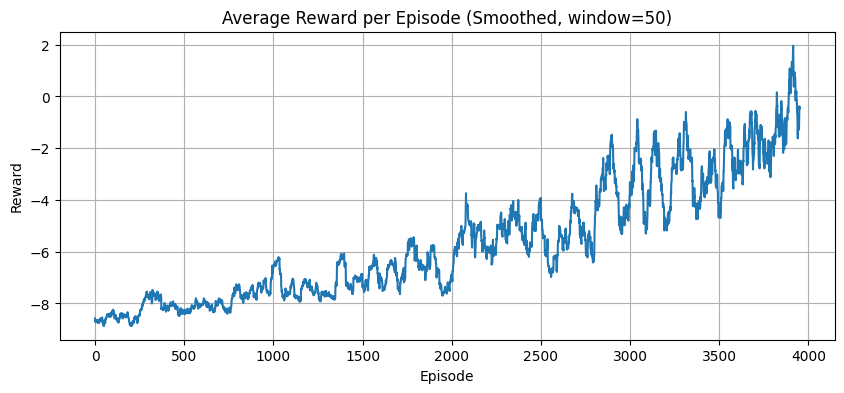

In [33]:
# Cell 10: Plot training rewards
plt.figure(figsize=(10,4))
plt.plot(np.convolve(episode_rewards, np.ones(50)/50, mode='valid'))
plt.title("Average Reward per Episode (Smoothed, window=50)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()



FINAL EVALUATION RESULTS
----------------------------------------
Success Rate (%)              : 15.3
Average Wrong Guesses         : 5.702
Average Repeated Guesses      : 0.0
Final Score                   : -28357.0


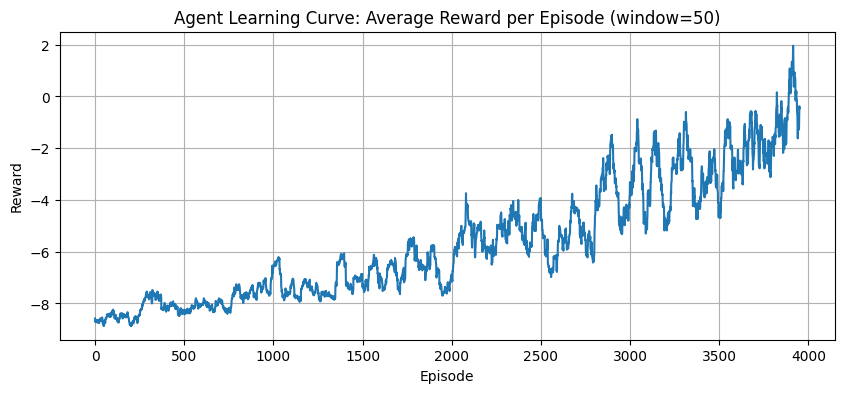

In [34]:
# Cell 11: Evaluation summary and learning plots

def evaluate_agent(model, words, n_games=1000):
    wins = wrong = repeated = 0
    for _ in range(n_games):
        w = random.choice(words)
        env = HangmanEnv(w, hmm, 6, corpus)
        obs = env.reset()
        done = False
        while not done:
            state = obs_to_vec(obs)
            mask = mask_actions(obs)
            with torch.no_grad():
                q_vals = model(torch.tensor(state).float().to(DEVICE).unsqueeze(0)).cpu().numpy().squeeze()
            q_vals -= (1 - mask) * 1e6
            action = int(np.argmax(q_vals))
            obs, r, done, info = env.step(alphabet[action])
        if info.get("result") == "win":
            wins += 1
        wrong += env.wrong
        repeated += env.repeated

    success_rate = wins / n_games
    avg_wrong = wrong / n_games
    avg_repeated = repeated / n_games
    final_score = (success_rate * n_games) - (wrong * 5) - (repeated * 2)

    results = {
        "Success Rate (%)": round(success_rate * 100, 2),
        "Average Wrong Guesses": round(avg_wrong, 3),
        "Average Repeated Guesses": round(avg_repeated, 3),
        "Final Score": round(final_score, 3)
    }
    return results

#Evaluate
results = evaluate_agent(policy_net, test_words, n_games=1000)

print("\nFINAL EVALUATION RESULTS")
print("-" * 40)
for k, v in results.items():
    print(f"{k:30}: {v}")

#Plot learning curve
plt.figure(figsize=(10, 4))
plt.plot(np.convolve(episode_rewards, np.ones(50)/50, mode="valid"))
plt.title("Agent Learning Curve: Average Reward per Episode (window=50)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()
